Океей. Є два варіанти - запустити щось готове і адаптувати під себе, або трішки благотодніше - реалізувати щось власноруч.

Звісно благородно і більш показово було б якби я робив то сам - але треба бути приземленим і ближчим до реалій - **красти і адаптовувати**, щоб отримати працездатний продукт в короткі терміни.

На днях бачив новеньку роботу Yifan Wang∗ Xingyi He∗ Sida Peng Dongli Tan Xiaowei Zhou†
під назвою Efficient LoFTR: Semi-Dense Local Feature Matching with Sparse-Like Speed
*(👉Zhejiang unveils efficient LoFTR: novel LoFTR-inspired algorithm for efficien semidense matches across images: up to 2.5× faster than LoFTR, superior to previous SOTA pipeline (SuperPoint + LightGlue).)*

Копнув трішки під історію створення і вийшов на конференцію Computer Vision and Pattern Recognition Conference (CVPR). 

Вирішив, що якщо тут китайці+всесвітня конференція - то треба копнути сюди.

Першим що мені трапилось і те що я ніби як пробував недавно запускати та був задоволений результатом - це **SuperGlue: Learning Feature Matching with Graph Neural Networks**

Компанії Magic Leap, Inc.
https://psarlin.com/superglue/

5хв налаштовування оточення під pytorch та CUDA - і вуаля - я бачу демку, яка працює на базі моєї веб-камери.  (conda env create -f condaenv.yml якщо уже є CUDA 11.3 в моєму випадку)

Старенька GTX-1650 на 4гб VRAM видала мені в режимі 640х480 - добротні 6.5 fps.
Візуально якість гарна, у кожного метчу є власний відсоток збігу, який відображається кольором на візуалізації.

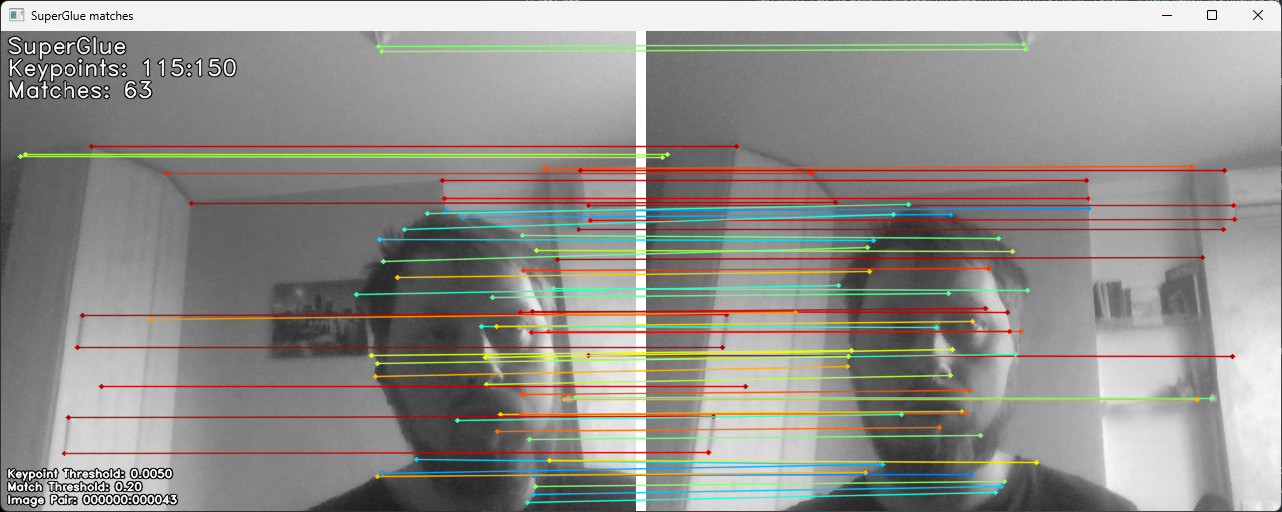

Нот бед, але треба спочатку потестувати на наших даних, а потім вивести метрику подібності.

In [209]:
from pathlib import Path
import argparse
import random
import numpy as np
import matplotlib.cm as cm
import torch


from src.matching import Matching
from src.utils import (compute_pose_error, compute_epipolar_error,
                          estimate_pose, make_matching_plot,
                          error_colormap, AverageTimer, pose_auc, read_image,
                          rotate_intrinsics, rotate_pose_inplane,
                          scale_intrinsics)

torch.set_grad_enabled(False)

In [210]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Running inference on device \"{}\"'.format(device))
nkeypoints = 500
config = {
        'superpoint': {
            'nms_radius': 4, #SuperPoint Non Maximum Suppression (NMS) radius
            'keypoint_threshold': 0.005, #SuperPoint keypoint detector confidence threshold
            'max_keypoints': nkeypoints #Maximum number of keypoints detected by Superpoint
        },
        'superglue': {
            'weights': 'outdoor', #SuperGlue weights
            'sinkhorn_iterations': 20, #Number of Sinkhorn iterations performed by SuperGlue
            'match_threshold': 0.2 #SuperGlue match threshold
        }
    }
matching = Matching(config).eval().to(device)

Running inference on device "cuda"
Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)


Підготовка завершена, час підвантажувати наші зображення. До прикладу візьмемо ці дві картинки
dataset\RGB\uav_images\DJI_0267.JPG

dataset\RGB\sat_images\DJI_0267.JPG

вони практично відповідають одній місцевості 


(ресайзнув і склеїв, щоб не завантажували юпітер)

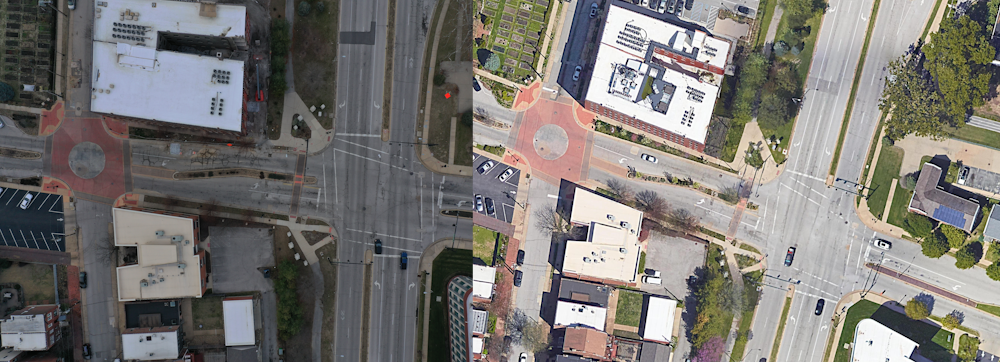

In [211]:
image0, inp0, scales0 = read_image("dataset\\RGB\\uav_images\\DJI_0267.JPG", device, [1024,840], 0, False)
image1, inp1, scales1 = read_image("dataset\\RGB\\sat_images\\DJI_0267.JPG", device, [1024,840], 0, False)

In [212]:
pred = matching({'image0': inp0, 'image1': inp1})
pred = {k: v[0].cpu().numpy() for k, v in pred.items()}
kpts0, kpts1 = pred['keypoints0'], pred['keypoints1']
matches, conf = pred['matches0'], pred['matching_scores0']

print(len(matches), "matches found")

500 matches found


На моєму ресайзі до 1024х840 і при використанні 1650 - кадр виконався за 0.6с. Це ок, бо є багато чого оптимізовувати.

In [50]:
valid = matches > -1
mkpts0 = kpts0[valid]
mkpts1 = kpts1[matches[valid]]
mconf = conf[valid]
color = cm.jet(mconf)
text = [
    'SuperGlue',
    'Keypoints: {}:{}'.format(len(kpts0), len(kpts1)),
    'Matches: {}'.format(len(mkpts0)),
]

k_thresh = matching.superpoint.config['keypoint_threshold']
m_thresh = matching.superglue.config['match_threshold']
small_text = [
    'Keypoint Threshold: {:.4f}'.format(k_thresh),
    'Match Threshold: {:.2f}'.format(m_thresh),
    'Image Pair: {}:{}'.format("uav_images", "sat_images"),
]

make_matching_plot(
    image0, image1, kpts0, kpts1, mkpts0, mkpts1, color,
    text, 'im.jpg', True,
    True, False, 'Matches', small_text)

На виході красива картинка з метчами.

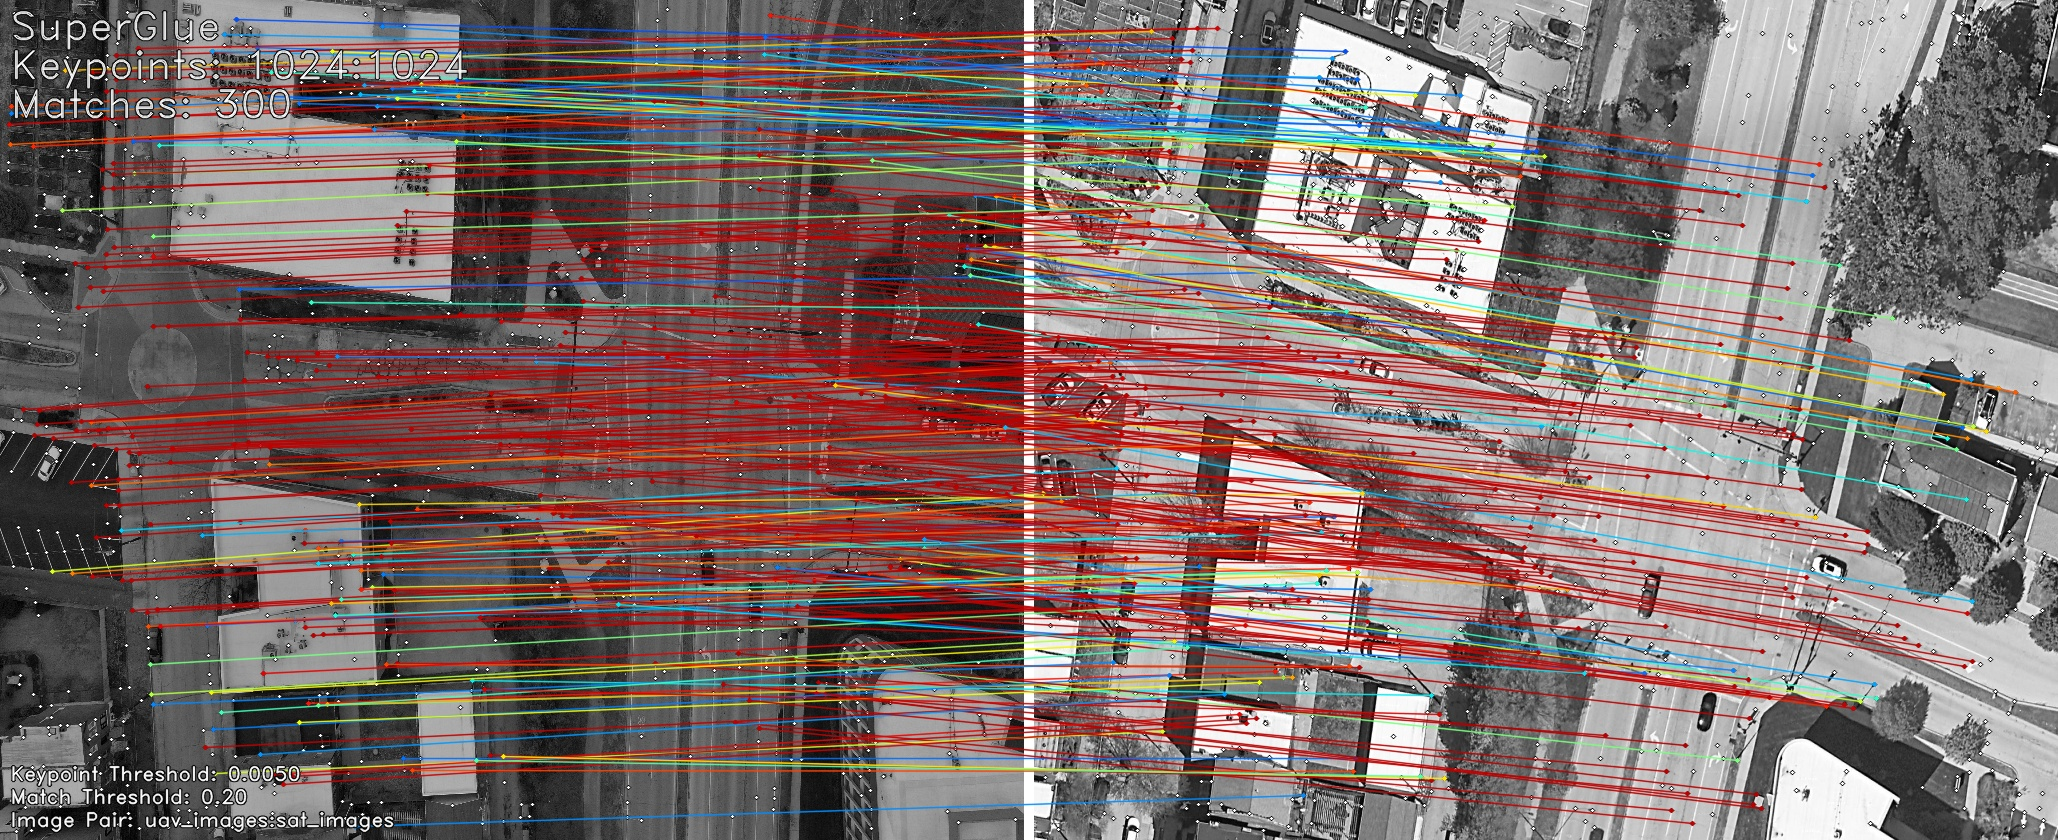

Класно, схоже на правду, але нам треба ще порахувати наскільки вони схожі.

Та наскільки коректно працює алгоритм.

Як я зрозумів - це прийнято робити - виписуючи ground truth info - реальну інфу про положення та висоту та порівнювати з результатами роботи алгоритму.
Такого собі дозволити не можу через фактор часу, тому буду імпровізувати і довіряти порахованим конфіденсам метчів.


In [42]:
print(np.average(conf))
goodOnesCount = np.sum(conf > 0.2)
print(goodOnesCount)

0.18017553
110


Середній конфіденс метчів становить 0.18, при цьому з 500 - лише 110 подолали мій поріг в 0.2 конфіденсу.
Так як об'єктивно схожість 1 буде у картинки тільки у самої з собою - ми будемо працювати з меншими значеннями, задавши поріг та вважатимемо якесь значення як таке, що близьке до "картинки схожі"

Просто вважати середній conf показником якості - **недоречно**, бо ми так можемо через однакову машину в місті і чистому полі вважати, що середній конф близький до 100. Тому, думаю, доречно рахувати сумарний конф. Це буде водночас і від якості сработок залежати і від їх кількості. А так як поріг кількості знайдених точок ми задаємо в залежності від ситуації (в цьому демо це 500), то ділитимемо на це число.

Щоб розуміти з чим ми маємо справу - ударимось трішки в емпірику і подивимось який результат буде з відносно різними картинками.


 **Пропишемо метод суцільним шматком для того, щоб було зручніше юзати.**
 

In [109]:
#ОСНОВНИЙ МЕТОД

import time 
import torch

torch.set_grad_enabled(False)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Running inference on device \"{}\"'.format(device))
nkeypoints = 500
config = {
        'superpoint': {
            'nms_radius': 4, #SuperPoint Non Maximum Suppression (NMS) radius
            'keypoint_threshold': 0.005, #SuperPoint keypoint detector confidence threshold
            'max_keypoints': nkeypoints #Maximum number of keypoints detected by Superpoint
        },
        'superglue': {
            'weights': 'outdoor', #SuperGlue weights
            'sinkhorn_iterations': 20, #Number of Sinkhorn iterations performed by SuperGlue
            'match_threshold': 0.2 #SuperGlue match threshold
        }
    }
matching = Matching(config).eval().to(device)
print("config created")


def calculateSimilarity(filename1:str, filename2:str):
    image0, inp0, scales0 = read_image(filename1, device, [1024,840], 0, False)
    image1, inp1, scales1 = read_image(filename2, device, [1024,840], 0, False)
    pred = matching({'image0': inp0, 'image1': inp1})
    pred = {k: v[0].cpu().numpy() for k, v in pred.items()}
    kpts0, kpts1 = pred['keypoints0'], pred['keypoints1']
    matches, conf = pred['matches0'], pred['matching_scores0']
    return sum(conf)/nkeypoints

Running inference on device "cuda"
Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)
config created


Подивимось які показники будуть у ідеального прикладу зверху.

In [114]:
conf_city_different = calculateSimilarity("dataset\\RGB\\uav_images\\DJI_0267.JPG", "dataset\\RGB\\sat_images\\DJI_0267.JPG"  )
print(conf_city_different)

0.1801755130251986


Маємо 0.18, число виглядає замалим, але так як воно відображає майже ідеальний випадок - уявімо, що воно близьке до 1 (наприклад 0.2 - це і є 1)

In [115]:
print(0.180175/0.2)

0.900875


Тобто на ідеальному прикладі маємо 0.9 умовних одиниць. Запам'ятали)

Надалі будемо переводити в цей проміжок по дефолту, для кращого розуміння.

In [116]:
conf_city_different = calculateSimilarity("dataset\\RGB\\uav_images\\DJI_0267.JPG", "dataset\\RGB\\sat_images\\DJI_0542.JPG"  )
print(conf_city_different*5)

0.1608810055349022


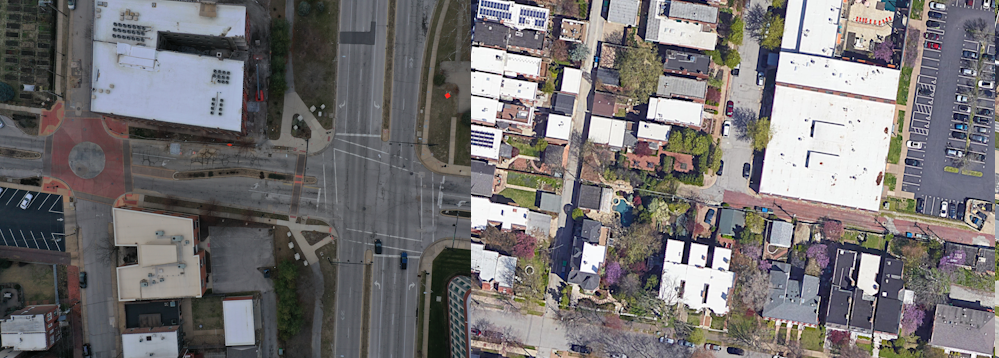

Бачимо фото зверху та 0.16 conf.


Маємо не прям нульовий конф, бо порівнювали урбаністичну забудову зі схожими дахами та машинами на дорогах.

Візуально це виглядає так (нагадаю, що чим теплішим є колір - тим більший конфіденс у зв'язку і тим більш схожі "дескриптори" у точок)

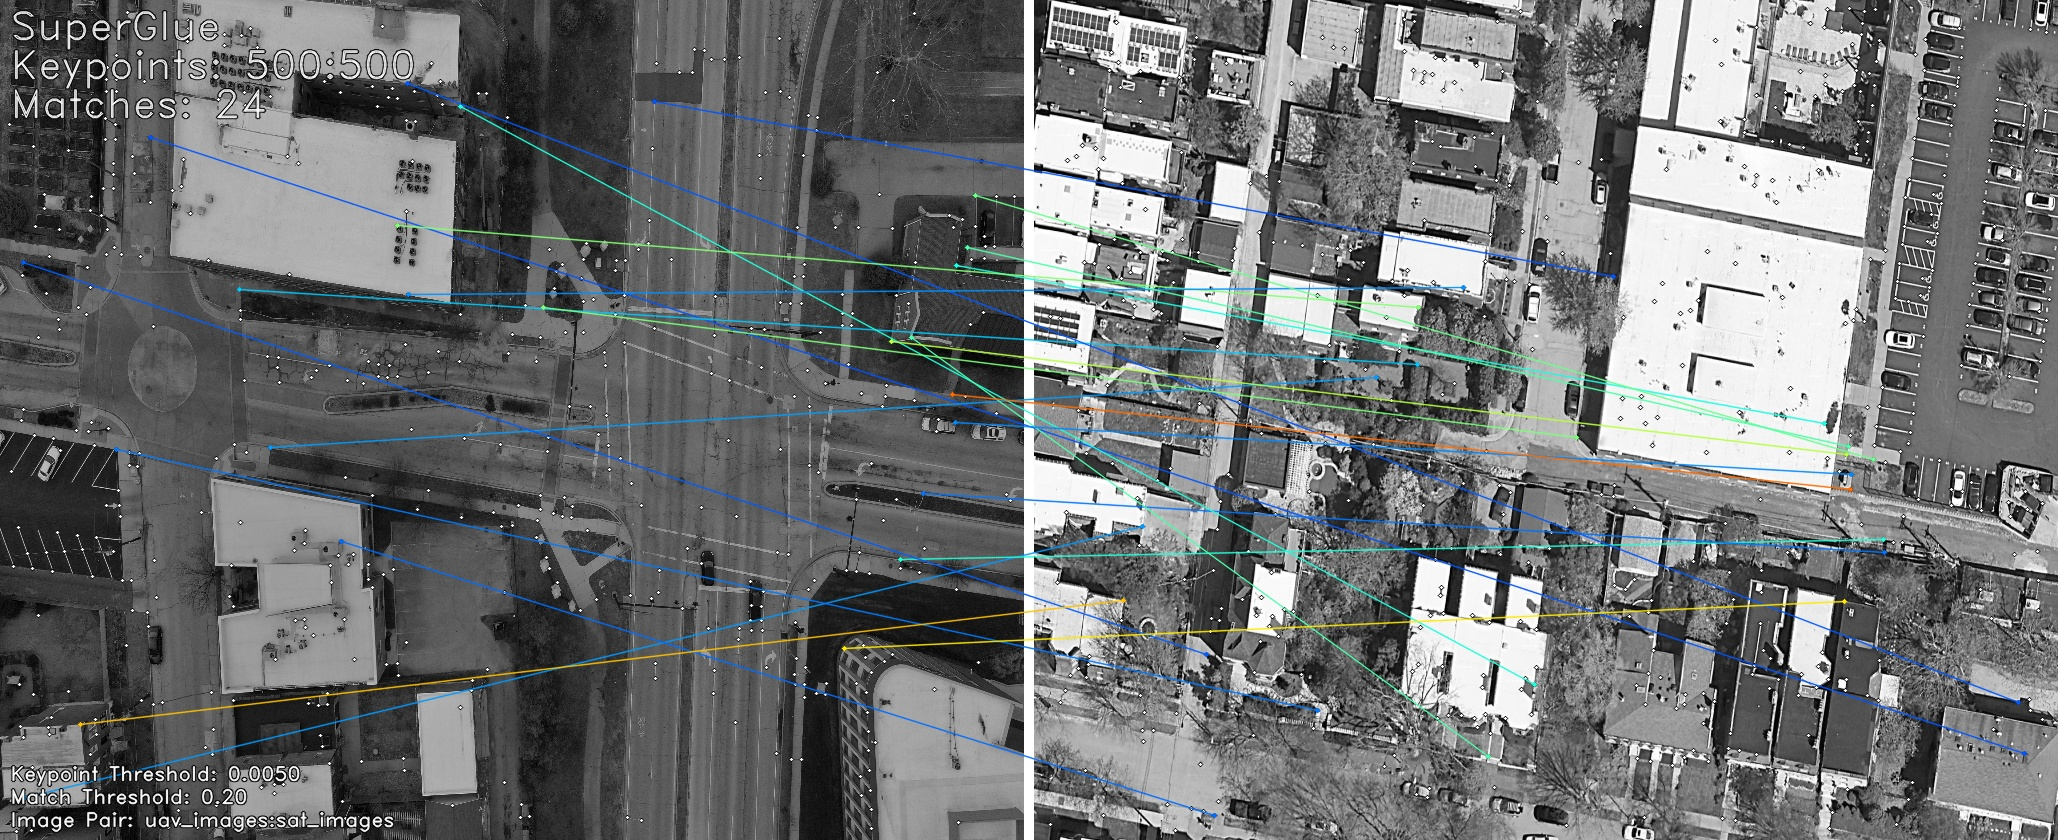

Ми бачимо нікчемні намагання алгоритму знайти хоч щось спільше, але якось не виходить.

Скористаюся ще папочкою false_sat_images для переконання в тому, що все +-працює. візьму щось типу цього:

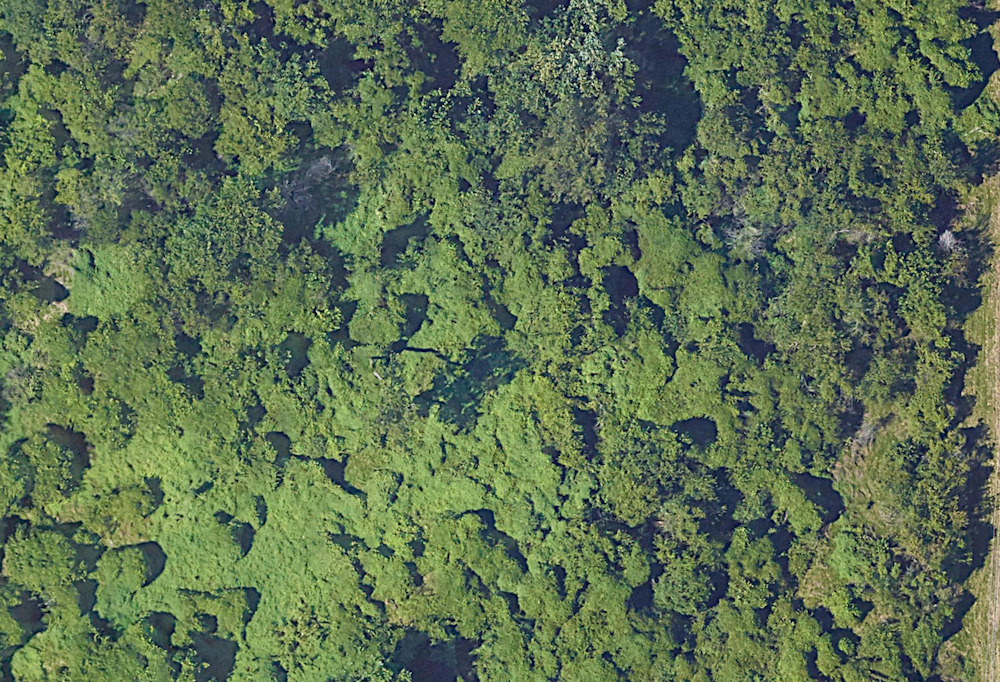

In [118]:
conf_city_different = calculateSimilarity("dataset\\RGB\\uav_images\\DJI_0267.JPG", "dataset\\RGB\\false_sat_images\\(38.6057500118208,-90.18113253425659), (38.604808168409335, -90.17933211254105).jpg"  )
print(conf_city_different*5)

0.06253381341230124


Бачимо, що тут середній конфіденс становить уже 0.06, в 15 разів менший ніж на "схожих" які ми визначили на око. 

Оновлю основний метод, з урахуванням нашої поправки

In [119]:
def calculateSimilarity(filename1:str, filename2:str):
    image0, inp0, scales0 = read_image(filename1, device, [1024,840], 0, False)
    image1, inp1, scales1 = read_image(filename2, device, [1024,840], 0, False)
    pred = matching({'image0': inp0, 'image1': inp1})
    pred = {k: v[0].cpu().numpy() for k, v in pred.items()}
    kpts0, kpts1 = pred['keypoints0'], pred['keypoints1']
    matches, conf = pred['matches0'], pred['matching_scores0']
    return (sum(conf)/nkeypoints)*5

Глянемо на час виконання, але врахуймо, що виконуються зайві обрахування початкового зображення ( я це лишаю для чистоти експеременту) але пам'ятаймо, що витрачений час можна скоротити майже вдвічі на продакшені

In [120]:
print("Схожі картинки, ймовірно в одному місці")
start = time.time()
print(calculateSimilarity("dataset\\RGB\\sat_images\\DJI_0267.JPG", "dataset\\RGB\\uav_images\\DJI_0267.JPG"))
print(time.time() - start, " секунд")

print("\nДві картинки в контексті міста, але різні")
start = time.time()
print(calculateSimilarity("dataset\\RGB\\sat_images\\DJI_0542.JPG", "dataset\\RGB\\uav_images\\DJI_0267.JPG"))
print(time.time() - start, " секунд")

print("\nМісто та ліс")
start = time.time()
print(calculateSimilarity("dataset\\RGB\\sat_images\\DJI_0542.JPG", "dataset\\RGB\\false_sat_images\\(38.6057500118208,-90.18113253425659), (38.604808168409335, -90.17933211254105).jpg"))
print(time.time() - start, " секунд")

Схожі картинки, ймовірно в одному місці


0.9003741966682719
0.6561233997344971  секунд

Дві картинки в контексті міста, але різні
0.16087818590924144
0.5542776584625244  секунд

Місто та ліс
0.06987191567197443
0.49100351333618164  секунд


Пора вводити якісь метрики (себто які пороги вважати адекватними). Продивлюся які будуть показники коли я прожену хоч пару сотень фото з false_sat.

In [121]:
import os
confs = []
for image in os.listdir("dataset\\RGB\\false_sat_images") [:200] :
    confs.append( calculateSimilarity("dataset\\RGB\\sat_images\\DJI_0542.JPG", os.path.join("dataset\\RGB\\false_sat_images", image))  )

In [122]:
print(np.mean(confs))
print(np.median(confs))
print(np.max(confs))
print(np.min(confs))

0.09425806571073773
0.0915612084325403
0.30757099015638234
0.00038847820833325385


Бачимо максимум в 30%, мало. Дивимось далі.Візуалізую щільність 

In [123]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt


<Axes: ylabel='Frequency'>

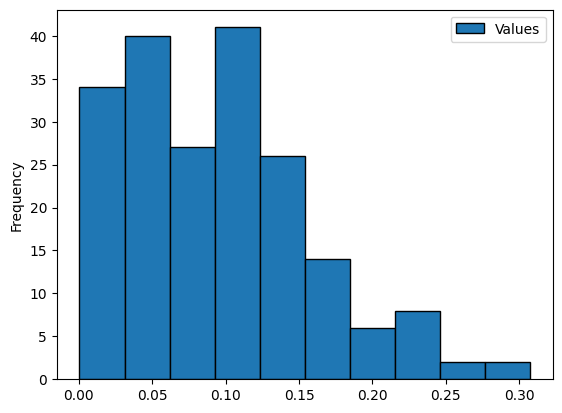

In [124]:
df = pd.DataFrame(confs, columns=['Values'])
df.plot.hist(bins=10, edgecolor='black')


0.1 перемагає, як і було в тексті вище. Тепер перевіримо що буде на нормальній папці, де присутні відповідні знімки.

In [125]:
import os
confs = []
for image in os.listdir("dataset\\RGB\\uav_images") [:100] :
    confs.append( calculateSimilarity("dataset\\RGB\\sat_images\\DJI_0267.JPG", os.path.join("dataset\\RGB\\uav_images", image))  )

In [126]:
print(np.mean(confs))
print(np.median(confs))
print(np.max(confs))
print(np.min(confs))

0.2959792364325363
0.20780686267418785
0.9299607823140105
0.08599142708815634


Подивимось на графік

<Axes: ylabel='Frequency'>

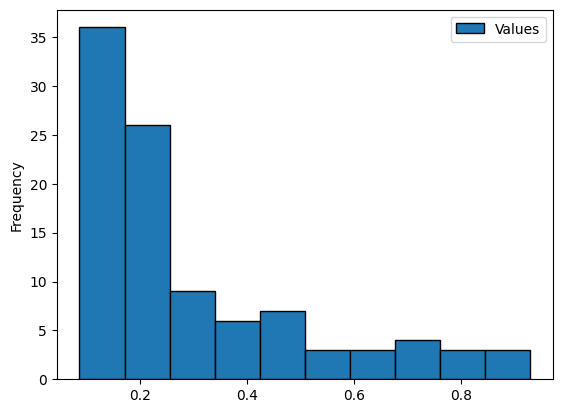

In [127]:
df = pd.DataFrame(confs, columns=['Values'])
df.plot.hist(bins=10, edgecolor='black')

Мода лишилась на рівні 0.1, але з'явився "Хвіст праворуч" та значення ближчі до 1. Все тому що ми додали даних, які трішки перекривають шукану зону.

Дослідимо який буде розподіл значень над тим перехрестям, на якому тестували.

In [129]:
import os
confs = []
for image in os.listdir("dataset\\RGB\\that_crossroad"):
    confs.append( calculateSimilarity("dataset\\RGB\\uav_images\\DJI_0267.JPG", os.path.join("dataset\\RGB\\that_crossroad", image))  )
    print(os.path.join("dataset\\RGB\\that_crossroad", image),confs[-1] )

dataset\RGB\that_crossroad\DJI_0267.JPG 0.900877565125993
dataset\RGB\that_crossroad\DJI_0268.JPG 0.9044929834060894
dataset\RGB\that_crossroad\DJI_0269.JPG 0.834931241251179
dataset\RGB\that_crossroad\DJI_0270.JPG 0.7360796963325266
dataset\RGB\that_crossroad\DJI_0271.JPG 0.5342496549642965
dataset\RGB\that_crossroad\DJI_0272.JPG 0.20163399162702264
dataset\RGB\that_crossroad\DJI_0273.JPG 0.10858321046922356


Всі тестові фото були відзняті на тому ж перехресті і з поступовим зсувом - зменшується поріг подібності до несуттєвих 0.3, з цього можна припустити на даному етапі, що поріг - це число в 0.5~0.6

In [130]:
print(np.mean(confs))
print(np.median(confs))
print(np.max(confs))
print(np.min(confs))

0.6029783347394758
0.7360796963325266
0.9044929834060894
0.10858321046922356


<Axes: ylabel='Frequency'>

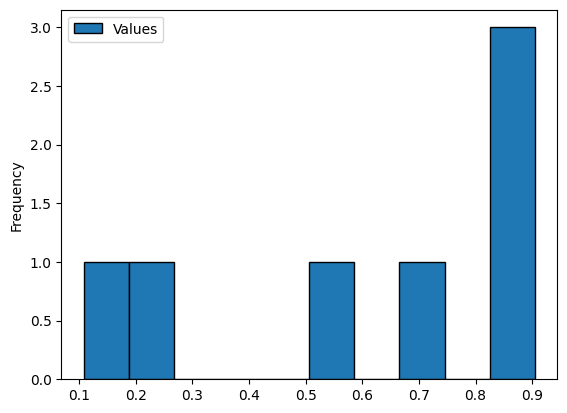

In [131]:
df = pd.DataFrame(confs, columns=['Values'])
df.plot.hist(bins=10, edgecolor='black')

Це все звісно класно. Але треба тести ближчі до проду. Обрахуємо кейпоінти на умовній сотні картинок і збережемо їх. Потім порівнюватимемо уже з ними.

In [215]:
from src.superpoint import SuperPoint
from src.superglue import SuperGlue
import json

class CalcOneKeypoints(torch.nn.Module):
    def __init__(self, config={}):
        super().__init__()
        self.superpoint = SuperPoint(config.get('superpoint', {}))
        self.superglue = SuperGlue(config.get('superglue', {}))

    def forward(self, data):
        pred0 = self.superpoint({'image': data['image0']})
        return pred0
oneCalc = CalcOneKeypoints(config).eval().to(device)



def calc_keypoints_for_dir(input_dir:str,output_dir:str):

    print('Looking for images in directory \"{}\"'.format(input_dir))
    print('Saving keypoints to directory \"{}\"'.format(output_dir))

    for image in os.listdir(input_dir):
        image0, inp0, scales0 = read_image(os.path.join(input_dir, image), device, [1024,840], 0, False)
        kpoints_tensor = oneCalc({'image0': inp0, 'image1': inp0})
        torch.save(kpoints_tensor, os.path.join(output_dir, image+".pt"))

Loaded SuperPoint model


Loaded SuperGlue model ("outdoor" weights)


In [216]:
calc_keypoints_for_dir("dataset\\RGB\\that_crossroad", "keypoints")

Looking for images in directory "dataset\RGB\that_crossroad"
Saving keypoints to directory "keypoints"


Порахували 7 наборів кейпоінтів (уявімо, що зробили це вдома) за 2.6 секунди на моїй 1650....

In [217]:
def calc_keypoints_for_image(input_dir:str):
    image0, inp0, scales0 = read_image(input_dir , device, [1024,840], 0, False)
    return oneCalc({'image0': inp0, 'image1': inp0})
    

In [218]:
keypointsFromCamera = calc_keypoints_for_image("dataset\\RGB\\uav_images\\DJI_0267.JPG")

In [219]:
class MatchPoints(torch.nn.Module):
    def __init__(self, config={}):
        super().__init__()
        self.superpoint = SuperPoint(config.get('superpoint', {}))
        self.superglue = SuperGlue(config.get('superglue', {}))

    def forward(self, pred0, pred1):
        pred = {}
        data =  ['image0', 'image1']
        print(type(pred0))
        pred = {**pred, **{k+'0': v for k, v in pred0.items()}}
        pred = {**pred, **{k+'1': v for k, v in pred1.items()}}
        data = {**data, **pred}

        for k in data:
            if isinstance(data[k], (list, tuple)):
                data[k] = torch.stack(data[k])

        # Perform the matching
        pred = {**pred, **self.superglue(data)}

        return pred
    
matcher = MatchPoints(config).eval().to(device)

camm = torch.load('keypoints\\DJI_0267.JPG.pt')  

print(matcher(camm,keypointsFromCamera ) )

Loaded SuperPoint model


Loaded SuperGlue model ("outdoor" weights)
<class 'dict'>


UnboundLocalError: local variable 'data' referenced before assignment